# Image Captioning Project using Resnet50

This project is to define and train an image-to-caption model, that can produce descriptions for real world images!

# Import stuff

In [1]:
import torch
import torch.nn as nn
from typing import Type
from torch import Tensor
import torchvision.models as models
import torch.optim as optim
from zipfile import ZipFile
from google.colab import drive
from IPython import get_ipython
import sys, time, os, warnings
import torchvision.transforms as transforms

#Imports for Dataloader
import spacy
from collections import Counter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

#Imports to read text data
import pandas as pd

#Imports to plot image and its captions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Download data

Flicker8k dataset has been used for this project.

Dataset Link: GitHub - goodwillyoga/Flickr8k_dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#location of the data
data_location =  "/content/drive/MyDrive/wrk_dir"
!ls $data_location

image_path = data_location+"/flickr8k/images/"
caption_file = data_location + '/cpt/captions.txt'
dev_caption_file = data_location + '/txt/Flickr_8k.devImages.txt'
test_caption_file = data_location + '/txt/Flickr_8k.testImages.txt'
train_caption_file = data_location + '/txt/Flickr_8k.trainImages.txt'

cpt  flickr8k  txt


In [4]:
#reading the text data
run_type = "Train"

df_8k = pd.read_csv(caption_file)
df_dev = pd.read_csv(dev_caption_file)
df_test = pd.read_csv(test_caption_file)
df_train = pd.read_csv(train_caption_file)

print("There are {} image to captions in 8K file".format(len(df_8k)))
print("There are {} image to captions in Dev".format(len(df_dev)))
print("There are {} image to captions in test".format(len(df_test)))
print("There are {} image to captions in train".format(len(df_train)))

if run_type == "Dev":
  cpt_fle_df=pd.merge(df_dev,df_8k, on='image')
elif run_type == "Test":
  cpt_fle_df=pd.merge(df_test,df_8k, on='image')
elif run_type == "Train":
  cpt_fle_df=pd.merge(df_train,df_8k, on='image')
else:
  cpt_fle_df = df_8k

print("There are {} image to captions".format(len(cpt_fle_df)))
cpt_fle_df.head(10)

There are 40455 image to captions in 8K file
There are 1000 image to captions in Dev
There are 1000 image to captions in test
There are 6000 image to captions in train
There are 30000 image to captions


,image,caption
0,2513260012_03d33305cf.jpg,A black dog is running after a white dog in th...
1,2513260012_03d33305cf.jpg,Black dog chasing brown dog through snow
2,2513260012_03d33305cf.jpg,Two dogs chase each other across the snowy gro...
3,2513260012_03d33305cf.jpg,Two dogs play together in the snow .
4,2513260012_03d33305cf.jpg,Two dogs running through a low lying body of w...
5,2903617548_d3e38d7f88.jpg,A little baby plays croquet .
6,2903617548_d3e38d7f88.jpg,A little girl plays croquet next to a truck .
7,2903617548_d3e38d7f88.jpg,The child is playing croquette by the truck .
8,2903617548_d3e38d7f88.jpg,The kid is in front of a car with a put and a ...
9,2903617548_d3e38d7f88.jpg,The little boy is playing with a croquet hamme...


#Plotting Images

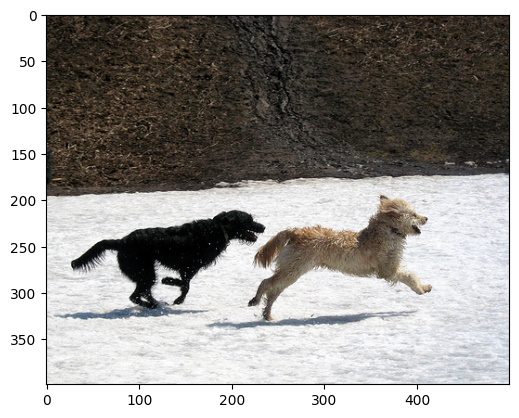

Caption: A black dog is running after a white dog in the snow .
Caption: Black dog chasing brown dog through snow
Caption: Two dogs chase each other across the snowy ground .
Caption: Two dogs play together in the snow .
Caption: Two dogs running through a low lying body of water .


In [5]:
#Plot image and its captions
#select any index from the whole dataset
#single image has 5 captions
#so, select indx as: 0,5,10,15...
data_idx = 0

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
print_image_path = image_path + cpt_fle_df.iloc[data_idx,0]
img=mpimg.imread(print_image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx
for i in range(data_idx,data_idx+5):
    print("Caption:",cpt_fle_df.iloc[i,1])

#Tokanization
Create new classes

In [6]:
#using spacy for the better text tokenization
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [7]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [8]:
#testing the vocab class
v = Vocabulary(freq_threshold=1)

v.build_vocab(["this is me"])
print(v.stoi)
print(v.numericalize("this is me"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'me': 6}
[4, 5, 6]


In [9]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

# Creating Dataset

In [10]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file_df,transform=None,freq_threshold=5
                 ):
        self.root_dir = root_dir
        # self.df = pd.read_csv(caption_file)
        self.df = captions_file_df
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        captionvec = torch.tensor(caption_vec)

        return img, captionvec

In [11]:
image_size = (224,224)

transformer = transforms.Compose([
    transforms.Resize(image_size),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [12]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
dataset =  FlickrDataset(
    root_dir = image_path,
    captions_file_df = cpt_fle_df,
    transform=transformer
)

# Dataloader

In [14]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

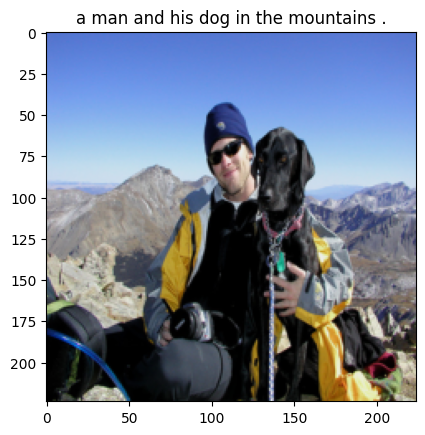

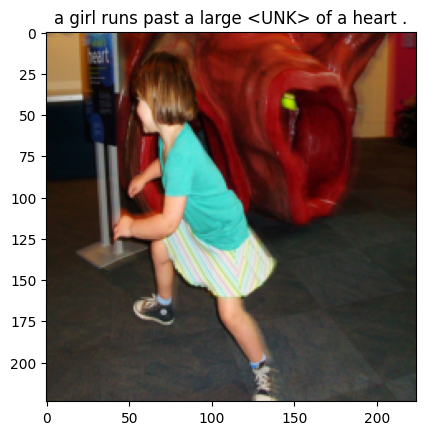

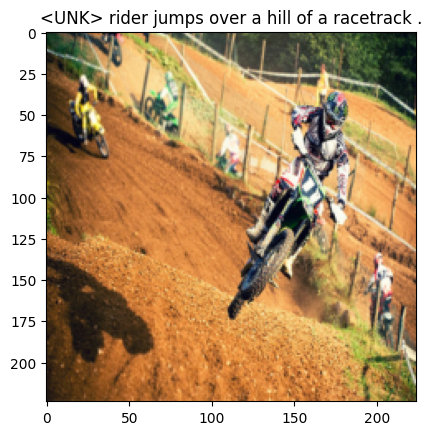

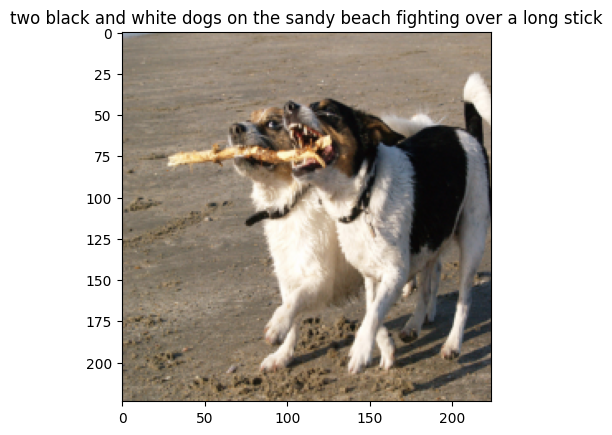

In [15]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

#Initiating Model

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

    def forward(self,images):
        features = self.resnet(images)
#         print(f"resenet features shape - {features.shape}")
        features = features.view(features.size(0),-1)
#         print(f"resenet features viewed shape - {features.shape}")
        features = self.embed(features)
#         print(f"resenet features embed shape - {features.shape}")
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self,features, captions):
        # vectorize the caption
#         print(f"captions - {captions[:,:-1]}")
#         print(f"caption shape - {captions[:,:-1].shape}")
        embeds = self.embedding(captions[:,:-1])
#         print(f"shape of embeds - {embeds.shape}")
        # concat the features and captions
#         print(f"features shape - {features.shape}")
#         print(f"features unsqueeze at index 1 shape - {features.unsqueeze(1).shape}")
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
#         print(f"shape of x - {x.shape}")
        x,_ = self.lstm(x)
#         print(f"shape of x after lstm - {x.shape}")
        x = self.fcn(x)
#         print(f"shape of x after fcn - {x.shape}")
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = inputs.size(0)

        captions = []

        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]


class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
# resenet features shape - torch.Size([4, 2048, 1, 1])
# resenet features viewed shape - torch.Size([4, 2048])
# resenet features embed shape - torch.Size([4, 400])
# caption shape - torch.Size([4, 14])
# shape of embeds - torch.Size([4, 14, 400])
# features shape - torch.Size([4, 400])
# features unsqueeze at index 1 shape - torch.Size([4, 1, 400])
# shape of x - torch.Size([4, 15, 400])
# shape of x after lstm - torch.Size([4, 15, 512])
# shape of x after fcn - torch.Size([4, 15, 2994])

In [17]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 360MB/s]


#Run Model

In [22]:
num_epochs = 2
print_every = 1000

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))


        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                print(f"features shape - {features.shape}")
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                print(caption)
                show_image(img[0],title=caption)

            model.train()

Output hidden; open in https://colab.research.google.com to view.

#Results
Took 18 minutes for 1000 pictures <br>
Took 122 minutes for 6000 pictures 11 epochs <br>
Took 58 minutes for 6000 pictures 2 epochs<br>

Credits:-<br>
Dataset: https://www.kaggle.com/code/mdteach/torch-data-loader-flicker-8k <br>
Resnet18: https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/ <br>
spacy: https://www.tutorialspoint.com/spacy/spacy_top_level_functions.htm <br>
Resnet50: https://www.kaggle.com/code/vimalpillai/flickr-image-caption-with-pytorch-resnet-lstm/notebook <br>